In [1]:
import pyreadr
import pandas as pd
import seaborn as sns
from IPython.display import display, HTML
from matplotlib import pyplot as plt
import numpy as np

In [2]:
result = pyreadr.read_r('./data/Anomaly_Detection_in_Streaming_Nonstationary_Temporal_Data/anomalous_stream.rda')

In [3]:
# Multivariate time series plot of a dataset obtained using a fiber optic cable. 
# Axis “Cable”represents individual points of the sensor cable. 
# There are 640 time series each with 1459 time points. 
# Yellow corresponds to low values and black to high values. 
# The black region near the upper endpoint of the cable (around 350–500) indicates
# the presence of an anomalous event 
# (e.g., intrusion attack, gas pipeline leak, etc.) 
# that has taken place during the 500–1300 time period.

,0,1,2,3,4,5,6,7,8,9,...,1449,1450,1451,1452,1453,1454,1455,1456,1457,1458
0,8053.2,3839.90,6354.60,9486.70,8064.80,6851.80,7337.50,8795.10,5121.60,9355.00,...,9600.90,11657.00,10982.00,10468.0,5917.10,8864.4,5505.70,5913.40,4420.50,3466.50
1,15046.0,9650.90,12059.00,14697.00,12649.00,8905.50,11615.00,10822.00,7686.10,9185.90,...,10626.00,16492.00,14722.00,17373.0,10737.00,11110.0,4937.50,3810.90,2393.50,991.74
2,7227.4,3367.30,3058.50,3444.70,3204.90,3814.90,3845.40,3649.80,3513.70,3143.30,...,14131.00,18257.00,15776.00,18226.0,11857.00,12013.0,3843.30,2690.20,1599.80,497.44
3,9413.1,4352.40,3611.80,2757.30,3790.00,3811.90,4466.20,3798.10,3204.00,2590.60,...,17122.00,17398.00,14781.00,23018.0,18287.00,22558.0,12575.00,9974.70,5851.50,1412.90
4,13797.0,6419.00,7126.30,6123.10,7702.20,4454.50,4993.90,4701.00,4057.00,3858.30,...,15613.00,14761.00,19370.00,36000.0,23203.00,20930.0,12328.00,6262.20,4720.40,2297.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,4271.8,553.33,498.95,688.66,570.49,579.92,529.99,555.77,409.27,451.89,...,2310.30,1707.10,2004.50,1672.2,1808.60,1746.1,1869.30,1806.80,1821.30,1438.00
636,4168.6,261.27,272.90,343.32,315.49,323.03,206.98,261.42,186.06,185.33,...,2124.80,1631.70,1887.20,2031.7,1503.90,1617.7,2031.20,1526.10,2208.90,2065.20
637,4152.2,232.03,162.81,250.19,218.59,157.87,216.45,193.87,184.08,263.62,...,2152.10,1603.20,2081.50,2014.1,1918.50,1773.2,1904.60,2241.90,1599.90,1788.80
638,4322.0,382.45,476.21,513.09,439.14,566.26,366.50,573.78,305.90,503.94,...,1627.00,1414.80,1520.50,1247.7,1441.70,1186.9,1024.70,1407.50,1192.60,1181.20


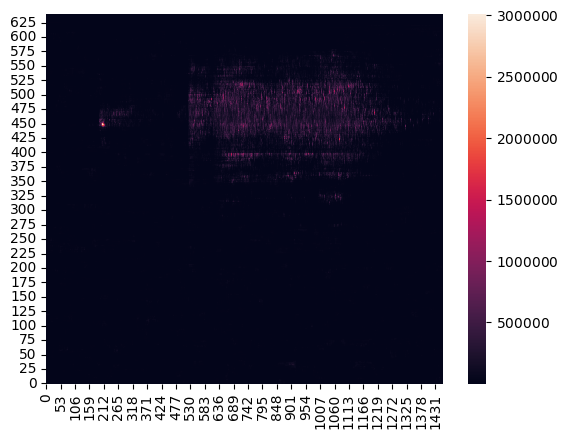

16039.699999999992


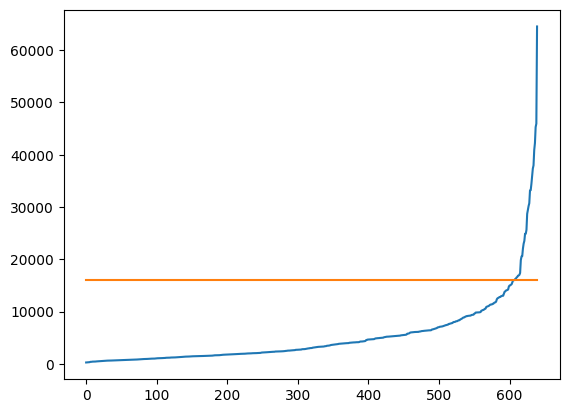

In [4]:
import matplotlib.ticker as tkr
formatter = tkr.ScalarFormatter(useMathText=True)
formatter.set_scientific(False)

data = []
cols = [i for i in range(1459)]
for ind, col in enumerate(result["anomalous_stream"].columns.to_list()):
    data.append(result["anomalous_stream"][col].to_list())

df_tmp = pd.DataFrame(data,columns=cols)
display(df_tmp)
sns.heatmap(df_tmp, fmt='g', cbar_kws={'format':formatter}).invert_yaxis()
plt.show()

aaa = df_tmp.iloc[:,400:401][400].to_list()
UCL = df_tmp.iloc[:,400:401][400].quantile(0.95)
print(UCL)
aaa.sort()
bbb = [UCL for i in aaa]
sns.lineplot(aaa)
sns.lineplot(bbb)
plt.show()

## Anomaly detection

t1=400

In [5]:
df = result["anomalous_stream"]

In [6]:
import report_utils
import pandas as pd
import numpy as np
import os
from sklearn.metrics import roc_auc_score, f1_score
import time
from tqdm import tqdm
import ready_pipelines
import tensorflow as tf
import random 
import multiprocessing
import logging
from pathlib import Path
from IPython.display import clear_output

In [7]:
df = result["anomalous_stream"]

In [8]:
def set_random(seed_value):
    # 1. Set `PYTHONHASHSEED` environment variable at a fixed value
    os.environ['PYTHONHASHSEED']=str(seed_value)
    # 2. Set `python` built-in pseudo-random generator at a fixed value
    random.seed(seed_value)
    # 3. Set `numpy` pseudo-random generator at a fixed value
    np.random.seed(seed_value)
    # 4. Set `tensorflow` pseudo-random generator at a fixed value
    tf.random.set_seed(seed_value)

In [9]:
def driver_func(runnable_pipe_func, SAVE_FOLDER, nr_subsets, nr_percentage, family_descr, N_ESTIMATORS, N_CORES, data_df, random_seeds):

    with multiprocessing.Pool(N_CORES) as pool:
        results = [pool.apply_async(runnable_pipe_func, (SAVE_FOLDER, nr_subsets, nr_percentage, str(family_descr), f"task_model_{str(task_ind).rjust(3,'0')}",data_df, seed)) for task_ind, seed in zip(range(N_ESTIMATORS), random_seeds)]
        
        all_seeds = []
        count = 0
        for r in tqdm(results, f"task_model_{str(count).rjust(3,'0')}"):
            tmp_res = r.get()
            all_seeds.append(tmp_res)
            count+=1
    
    return all_seeds

In [10]:
data_df = df
for nr_subsets in [2]:#[2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]:
    nr_subsets_ind = str(nr_subsets)
    for nr_percentage in [0.75]:#[0.75, 0.70, 0.65, 0.60]:
        nr_percentage_ind = str(nr_percentage).replace("0","").replace(".","").ljust(2,'0')
        for N_ESTIMATORS in [9]:#[11,13,15,17,19,21,23,25]:
            for tmp_seed_number in [2]:#range(1,35,1):
                print(tmp_seed_number)
                # N_ESTIMATORS = 61
                N_CORES = 11
                SAVE_FOLDER = f"./tmp_res_{N_ESTIMATORS}_{str(nr_subsets_ind)}_{nr_percentage_ind}"
                
                set_random(tmp_seed_number)
                Path(SAVE_FOLDER).mkdir(parents=True, exist_ok=True)

                log = logging.getLogger()
                for hdlr in log.handlers[:]:
                    log.removeHandler(hdlr)
                
                logging.basicConfig(level=logging.INFO, filename=f"{SAVE_FOLDER}/logs_info.log",
                                    format="CREATED_AT: %(asctime)s - MESSAGE: %(message)s")


                random_seeds = np.random.choice(9999, N_ESTIMATORS, replace=False).tolist()
                logging.info(f"'Params: N_ESTIMATORS: {N_ESTIMATORS} nr_subsets: {str(nr_subsets)} nr_percentage: {str(nr_percentage)} general_seed: {str(tmp_seed_number)} other_seeds: [{str(random_seeds)}]'")

                res = driver_func(ready_pipelines.run_pipeline_conv_ae_for_new_data_1, SAVE_FOLDER, 2, nr_percentage, str(tmp_seed_number), N_ESTIMATORS, N_CORES, data_df, random_seeds)

                time.sleep(10)
                
                df = report_utils.family_majority_voting(top_level_folder=SAVE_FOLDER, model_family=f"family_conv_ae_{str(tmp_seed_number)}")
                df = df[["predicted_anomaly_majority_voting"]]

                # df_original = pd.concat(data_df,ignore_index=False)
                # df_original = df_original[["anomaly"]]

                final_df = pd.concat([df,data_df], ignore_index=False, axis=1)
                # roc_number = roc_auc_score(final_df["anomaly"], final_df["predicted_anomaly_majority_voting"])
                # F1 = f1_score(final_df["anomaly"], final_df["predicted_anomaly_majority_voting"])

                # clear_output(wait=True)

                # logging.info(f"'AUC: {roc_number} F1: {F1}")
                
                # if roc_number>0.8300:
                #     break

2


task_model_000: 100%|██████████| 9/9 [00:51<00:00,  5.74s/it]

Index should not be repeated. Check your files


Dataset: 100%|██████████| 1/1 [00:00<00:00, 71.25it/s]
Model: 9it [00:00, 53.99it/s]


In [11]:
final_df

,predicted_anomaly_majority_voting,X1.1365e.07,X1.1585e.07,X1.1777e.07,X1.2246e.07,X1.2786e.07,X1.2318e.07,X1.1959e.07,X1.217e.07,X1.2249e.07,...,X1.143e.07.2,X1.1484e.07.1,X1.1518e.07.2,X1.1561e.07.3,X1.1409e.07.2,X1.1264e.07.1,X1.1184e.07,X1.1176e.07,X1.1239e.07.2,X1.1195e.07
0,0,8053.2,15046.00,7227.40,9413.1,13797.0,7659.0,6383.2,9135.3,8213.4,...,5068.6,5510.6,5800.3,5423.2,4915.9,4271.80,4168.60,4152.20,4322.00,4223.40
1,0,3839.9,9650.90,3367.30,4352.4,6419.0,2614.9,1682.7,4043.3,3115.3,...,1363.3,1646.1,1787.5,1548.2,1271.2,553.33,261.27,232.03,382.45,195.45
2,0,6354.6,12059.00,3058.50,3611.8,7126.3,3074.0,1680.1,3257.5,2884.4,...,1145.8,1642.4,1654.1,2177.3,1390.8,498.95,272.90,162.81,476.21,264.59
3,0,9486.7,14697.00,3444.70,2757.3,6123.1,2821.4,1672.0,3995.9,2273.7,...,1594.3,1997.1,2455.5,2596.3,1570.7,688.66,343.32,250.19,513.09,196.97
4,0,8064.8,12649.00,3204.90,3790.0,7702.2,2181.2,3407.9,2186.0,2564.5,...,1132.8,2283.9,2365.8,2103.5,1272.7,570.49,315.49,218.59,439.14,264.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,0,8864.4,11110.00,12013.00,22558.0,20930.0,5982.1,6525.2,3451.1,13167.0,...,4834.7,4321.8,3528.7,2229.5,2111.2,1746.10,1617.70,1773.20,1186.90,1015.10
1455,0,5505.7,4937.50,3843.30,12575.0,12328.0,3475.3,5284.9,5572.3,7354.1,...,4684.8,3911.0,4221.4,2512.4,2615.6,1869.30,2031.20,1904.60,1024.70,730.99
1456,0,5913.4,3810.90,2690.20,9974.7,6262.2,2369.1,3212.6,5958.5,8522.7,...,4791.9,4215.6,4161.9,2491.0,2198.8,1806.80,1526.10,2241.90,1407.50,804.59
1457,0,4420.5,2393.50,1599.80,5851.5,4720.4,2023.0,4149.9,5868.3,4152.9,...,4067.2,3897.9,3810.2,2187.5,3118.1,1821.30,2208.90,1599.90,1192.60,825.49


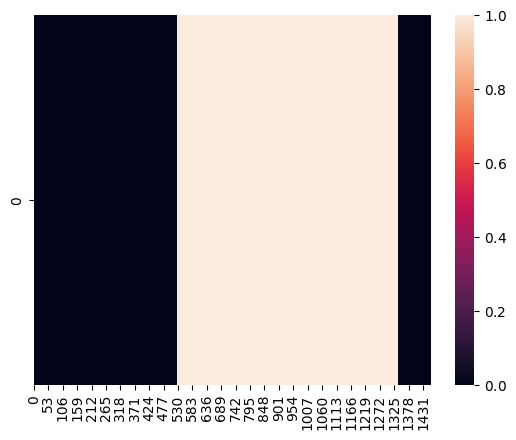

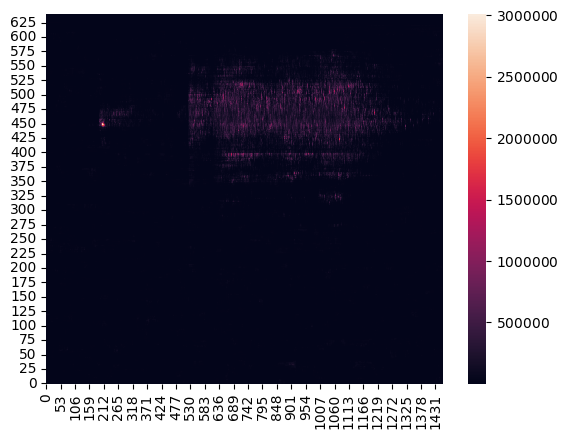

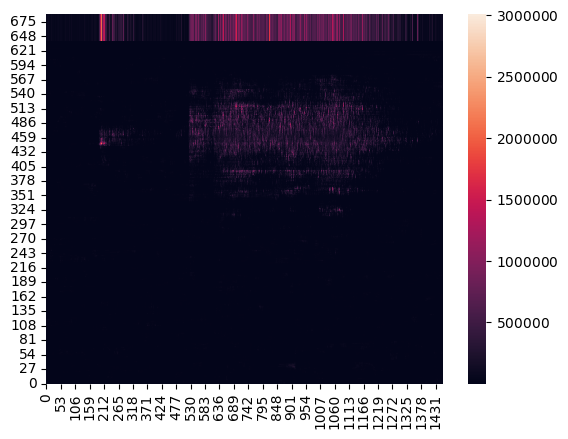

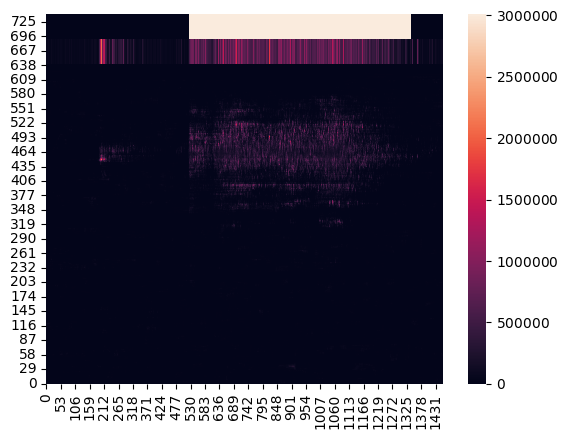

In [29]:
aaaa = final_df[["predicted_anomaly_majority_voting"]].copy(deep=True)

import matplotlib.ticker as tkr
formatter = tkr.ScalarFormatter(useMathText=True)
formatter.set_scientific(False)

data = []
cols = [i for i in range(1459)]
for ind, col in enumerate(aaaa.columns.to_list()):
    data.append(aaaa[col].to_list())

df_tmp = pd.DataFrame(data,columns=cols)
sns.heatmap(df_tmp, fmt='g', cbar_kws={'format':formatter}).invert_yaxis()
plt.show()

aaaa = final_df.drop(["predicted_anomaly_majority_voting"], axis=1).copy(deep=True)

import matplotlib.ticker as tkr
formatter = tkr.ScalarFormatter(useMathText=True)
formatter.set_scientific(False)

data = []
cols = [i for i in range(1459)]
for ind, col in enumerate(aaaa.columns.to_list()):
    data.append(aaaa[col].to_list())

df_tmp = pd.DataFrame(data,columns=cols)
sns.heatmap(df_tmp, fmt='g', cbar_kws={'format':formatter}).invert_yaxis()
plt.show()

aaaa = final_df.drop(["predicted_anomaly_majority_voting"], axis=1).copy(deep=True)
hmapsize = 50
for hmapsize_i in range(hmapsize):
    aaaa[f"asd_{hmapsize_i}"] = aaaa.max(axis=1)

import matplotlib.ticker as tkr
formatter = tkr.ScalarFormatter(useMathText=True)
formatter.set_scientific(False)

data = []
cols = [i for i in range(1459)]
for ind, col in enumerate(aaaa.columns.to_list()):
    data.append(aaaa[col].to_list())

df_tmp = pd.DataFrame(data,columns=cols)
sns.heatmap(df_tmp, fmt='g', cbar_kws={'format':formatter}).invert_yaxis()
plt.show()

aaaa = final_df.copy(deep=True)
hmapsize = 50
for hmapsize_i in range(hmapsize):
    aaaa[f"asd_{hmapsize_i}"] = aaaa.max(axis=1)

hmapsize = 50
max_final_df_number = final_df.max().max()
min_final_df_number = final_df.min().min()
aaaa[[f"asdasd_{hmapsize_i}" for hmapsize_i in range(hmapsize)]] = final_df.apply(lambda x: [max_final_df_number for hmapsize_i in range(hmapsize)] if x.predicted_anomaly_majority_voting > 0.5 else [min_final_df_number for hmapsize_i in range(hmapsize)], axis=1, result_type='expand')

import matplotlib.ticker as tkr
formatter = tkr.ScalarFormatter(useMathText=True)
formatter.set_scientific(False)

data = []
cols = [i for i in range(1459)]
for ind, col in enumerate(aaaa.columns.to_list()):
    data.append(aaaa[col].to_list())

df_tmp = pd.DataFrame(data,columns=cols)
sns.heatmap(df_tmp, fmt='g', cbar_kws={'format':formatter}).invert_yaxis()
plt.show()